# Conclusions

## Overall results
The aim of this project is to take a first pass at classifying court opinions, with the hope that a good classification method would be useful for lawyers. Our results are fairly promising; on the whole, we have been able to classify cases with above three-quarters accuracy.

We tried several different ways of classifying Supreme Court cases into a topic area, to identify which ones would be the most effective. Ultimately, we decided on two methods that performed the best. The first, called a "Support Vector Machine" (SVM), enabled us to assign topic areas to Supreme Court cases with 76% accuracy, when we tested our predictions against the Supreme Court Database's topic labels. This method performed generally well, though there were a few categories that it was often confused by; for example, the SVM tends to confuse cases in the "due process" category for cases in the "criminal procedure" category, since those two topics are similar.

On that note, the boundaries between the fourteen topic areas provided by the Supreme Court Database are not very well-defined. For example, the cases in the "criminal procedure," "due process," and "attorneys" categories are all very similar to each other and would be difficult to meaningfully distinguish. For this reason, we used another topic clustering method called "Naive Bayes," which allowed us to assign 3 clusters to each case based on which combination of clusters seemed to fit most appropriately. With this, we got an accuracy rate around 81%, which is an improvement over the method above. While this method is still shaky on some of the less common topic areas (like interstate amendments), it offers a robust and consistently successful way to automatically assign a few topic labels to Supreme Court cases by analyzing case syllabi.


## Applications and future research
Our project has only examined Supreme Court cases. Because Supreme Court cases have already been manually classified into issue areas, we can use Supreme Court cases to determine what features of judicial decisions best predict the issue area to which a decision should be assigned. On the other hand, since Supreme Court cases are manually classified, lawyers do not need computerized classification of Supreme Court cases. Rather, they need computerized classification of cases from other courts, such as Federal Appeals Court cases. This is probably the most important application of our project: using the models that we have created for classifying Supreme Court cases, we could attempt to classify Federal Appeals Court cases by issue area. We could additionally attempt to classify cases from other courts, but this would potentially be less accurate because other types of courts (e.g., state courts) have less in common with the Supreme Court than do Federal Appeals Courts (and, to a lesser extent, Federal District Courts). We feel that this could potentially be a very useful tool to facilitiate legal research, and it would be most beneficial for legal organizations that benefit the poor and those with access to few legal resources. As the *New York Times* noted in a recent article, public defenders and other pubic-interest lawyers, who typically have low budgets, are forced to spend enormous amounts of money on legal research [1]. Thus, digital tools that ease the legal research process disproportionately benefit lawyers with few resources, who usually work in poor and underserved communities.

Of course, our models are not perfect. Though we correctly predict the issue area of about 75-80% of cases, there is certainly room to improve. In future iterations of this project, there are at least two major improvements that we could make: first, instead of just examining single words as variables, we could use "n-grams" as variables; this means considering pair of words, triples of words, and so on. This may help to distinguish between similar issue areas where we have seen lots of overlap, such as taxation and economic activity. Second, we could try incorporating other features than just words. For example, we might include the year of the case, the location of origin of the case, and other variables in our models. These variables may marginally improve the predictive accuracy, for example if certain locations are more affiliated with cases in certain issue areas.

[1] http://www.nytimes.com/2015/10/29/us/harvard-law-library-sacrifices-a-trove-for-the-sake-of-a-free-database.html

## The rest of this file

The remainder of this file looks at the two best-performing methods, SVMs and naive bayes. We have copied much of the code from the corresponding iPython notebooks in order to be able to rerun these methods. To skip this copied code, just go to the following two sections of this document to see the important results: 

#### <a href='#svm_results'>SVM results</a>
#### <a href='#nb_results'>Naive Bayes results</a>

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import time
pd.set_option("display.width", 500)
pd.set_option("display.max_columns", 100)
pd.set_option("display.notebook_repr_html", True)
import seaborn as sns
sns.set_style("darkgrid")
sns.set_context("poster")

#SVM

##Import data
We now import all data from all cases (not just a subsample).

In [2]:
all_data = pd.read_csv('all_cases.csv')

In [3]:
all_data.head()

,full_cite,text,url,us_cite,case,case_id,caseId,docketId,usCite,docket,dateArgument,caseOriginState,jurisdiction,issueArea,decisionDirection,decisionType,lawType,majOpinWriter,majVotes,minVotes,year
0,Eagles v. Samuels 329 U.S. 304 (1946),"Eagles v. Samuels No. 59 Argued November 21, 1...",https://supreme.justia.com/cases/federal/us/32...,329 U.S. 304,Eagles v. Samuels,0,1946-020,1946-020-01,329 U.S. 304,59,11/21/1946,35,1,3,1,1,3,81,9,0,1946
1,Eagles v. Horowitz 329 U.S. 317 (1946),"Eagles v. Horowitz No. 58 Argued November 21, ...",https://supreme.justia.com/cases/federal/us/32...,329 U.S. 317,Eagles v. Horowitz,1,1946-021,1946-021-01,329 U.S. 317,58,11/21/1946,35,1,3,1,1,3,81,9,0,1946
2,Labor Board v. A. J. Tower Co. 329 U.S. 324 (1...,Labor Board v. A. J. Tower Co. No. 60 Argued N...,https://supreme.justia.com/cases/federal/us/32...,329 U.S. 324,Labor Board v. A. J. Tower Co.,2,1946-022,1946-022-01,329 U.S. 324,60,11/21/1946,NaN,1,7,2,1,3,82,8,1,1946
3,Gibson v. United States 329 U.S. 338 (1946),Gibson v. United States No. 23 Argued January ...,https://supreme.justia.com/cases/federal/us/32...,329 U.S. 338,Gibson v. United States,3,1946-023,1946-023-01,329 U.S. 338,23,1/2/1946,49,1,3,2,1,3,85,9,0,1946
4,Illinois v. Campbell 329 U.S. 362 (1946),Illinois ex rel. Gordon v. Campbell No. 35 Arg...,https://supreme.justia.com/cases/federal/us/32...,329 U.S. 362,Illinois v. Campbell,4,1946-024,1946-024-01,329 U.S. 362,35,3/28/1946,17,1,12,2,1,3,85,7,2,1946


##Train-test split
We split the cases in the entire dataset into training and test sets.

In [4]:
#select training and test cases (70% training, 30% test) and add a train-test column to the dataframe
#add train-test column to dataframe 
all_data['training'] = np.random.choice([0, 1], size=(len(all_data)), p=[.3, .7])

##Cleaning text

Just as in SVM.ipynb, the `get_parts` function below takes an opinion (a string), and returns the verbs and nouns in the opinion. 

In [5]:
import re 
regex1 = r"\(.\)"

In [10]:
from pattern.en import parse
from pattern.en import pprint
from pattern.en import conjugate, lemma, lexeme
from pattern.vector import stem, PORTER, LEMMA
from sklearn.feature_extraction import text
import string

#stopwords and punctuation
stopwords=text.ENGLISH_STOP_WORDS
punctuation = list('.,;:!?()[]{}`''\"@#$^&*+-|=~_')

def get_parts(opinion):
    oplow = opinion.lower()
    #REMOVING CHARACTERS: we have ugly text, and remove unnecssary characters.
    oplow = unicode(oplow, 'ascii', 'ignore') #remove non-unicode characters 
    oplow = str(oplow).translate(string.maketrans("\n\t\r", "   ")) #remove characters like \n 
    #justices (eg, Justice Breyer) are referred to as J. (eg,Breyer, J.); we remove the J., also JJ. for plural
    oplow = oplow.replace('j.','')
    oplow = oplow.replace('jj.','')
    oplow = oplow.replace('c.','') #remove C. for chief justice 
    oplow = oplow.replace('pp.','') #page numbers
    oplow = oplow.replace('  ','') #multiple spaces
    oplow = ''.join([i for i in oplow if not i.isdigit()]) #remove digits 
    oplow=re.sub(regex1, ' ', oplow)
    #Remove the Justia disclaimer at the end of the case, if it appears in the string
    justiadisclaimer = "disclaimer: official"
    if justiadisclaimer in oplow: 
        optouse = oplow.split(justiadisclaimer)[0]
    else:
        optouse = oplow
    
    #GET A LIST OF PRECEDENTS CITED IN THE OPINION 
    wordslist = optouse.split()
    #find precedents based on string 'v.' (eg, 'Brown v. Board')
    indices = [i for i in range(len(wordslist)) if wordslist[i]=='v.']
    precedents = [wordslist[i-1]+ ' ' + wordslist[i]+ ' ' + wordslist[i+1] for i in indices]
    
    #remove precedents, as we have already accounted for these
    for precedent in precedents:
        optouse = optouse.replace(precedent,'')
    
    #PARSE INTO LIST OF LISTS --> GET WORDS
    parsed = parse(optouse,tokenize=True,chunks=False,lemmata=True).split()
    verbsnouns = [] 
    i=0
    #Create lists of lists of verbs and nouns in each sentence.
    for sentence in parsed: #for each sentence 
        verbsnouns.append([])
        for token in sentence: #for each word in the sentence 
            if token[0] in punctuation or token[0] in stopwords or len(token[0])<=2:
                continue
            wordtouse = token[0]
            for x in punctuation:
                wordtouse = wordtouse.replace(x,' ') #if punctuation in word, take it out
            if token[1] in ['VB','VBZ','VBP','VBD','VBN','VBG','NN','NNS','NNP','NNPS']:
                verbsnouns[i].append(lemma(wordtouse)) #append the lemmatized word (we relemmatize because lemmata in parse does not seem to always work)
        i+=1  
    return(verbsnouns)

###Lists of words, vocabularies

First, the dataframe does seem to have one case that does not have a string type for the text, for some reason. This cell removes all cases whose text is not a string.

In [8]:
str_types = np.array(map(type, all_data.text)) == str
all_data = all_data[str_types]
all_data = all_data.reset_index(drop=True)
# should return true, if the text column is only strings
(np.array(map(type, all_data.text)) == str).all()

True

In the next cell, we run get_parts on all the opinions to get lists of verbs and nouns.

In [12]:
%%time 
words = []
for op in all_data.text:
    words.append(get_parts(op))

Wall time: 10min 37s


We create a list of issue areas (our y variable), which is in the same order as the cases in all_data (and thus matches the order of cases in verbwords, nounwords, etc.)

In [14]:
issue_areas = all_data.issueArea.tolist()

We next create vocabularies, and also create maps between word id's and words (and vice versa).

In [21]:
#create vocabs
vocab = list(set([word for sublist in words for subsublist in sublist for word in subsublist]))

In [22]:
#dictionaries: id --> word
id2word = dict(enumerate(vocab))
#dictionaries: word --> id
word2id = dict(zip(id2word.values(),id2word.keys()))

Finally, we create corpuses (one for each word type). Each corpus is a list of lists: each inner list corresponds to an opinion, and has as its elements tuples of the form `(wordid, count)`, where `count` refers to the number of times the word appears in the opinion. This is described in further detail in SVM.ipynb.

In [23]:
#this function takes a list of words, and outputs a list of tuples 
counter = lambda x:list(set([(i,x.count(i)) for i in x]))

#corpus_creator takes a list of lists of lists like verbwords, or a list of lists like precedents_all. 
#It also takes a word2id dictionary.
def corpus_creator(sentence_word_list,word2id):
    counter = lambda x:list(set([(word2id[i],x.count(i)) for i in x]))
    op_word_list = []
    if type(sentence_word_list[0][0])==list: #if list of lists of lists 
        for opinion in sentence_word_list: 
            #for each list (which corresponds to an opinion) in sentence_word_list, get a list of the words
            op_word_list.append([word for sublist in opinion for word in sublist])
    else: #if list of lists 
        op_word_list = sentence_word_list
    corpus = []
    for element in op_word_list: 
        corpus.append(counter(element))
    return(corpus)

This function takes a corpus and a number of words, and returns a matrix in which the element at row i and column j is the number of occurrences of word j in document i.

In [24]:
# takes a corpus and a number of words, and returns a matrix in which the element at row i and column j is the number of
# occurrences of word j in document i.
def corpus_to_mat(corpus, num_words):
    n = len(corpus)
    M = np.zeros((n, num_words))
    for i,doc in enumerate(corpus):
        for word,count in doc:
            M[i][word] = count
    return M

Now, we construct a corpus, split it into training and test subsets, and convert each one of those into a matrix (just like we did for the subsample in the cleaning file).

In [26]:
%%time
corpus = corpus_creator(words, word2id)

Wall time: 20.9 s


In [29]:
%%time
train_corpus = [corpus[i] for i in range(len(corpus)) if all_data['training'][i]==1]
train_mat = corpus_to_mat(train_corpus, len(vocab))

Wall time: 835 ms


In [30]:
%%time
test_corpus = [corpus[i] for i in range(len(corpus)) if all_data['training'][i]==0]
test_mat = corpus_to_mat(test_corpus, len(vocab))

Wall time: 379 ms


Next, we can apply a TF-IDF transformation (which is described in detail in the SVM file and elsewhere in our project) to downweight words that are very common.

In [35]:
from sklearn.feature_extraction.text import TfidfTransformer
#this function takes a training matrix of size n_documents_training*vocab_size and a test matrix
#of size n_documents_test*vocab_size. The function outputs the corresponding tfidf matrices.
#Note that we fit on the training data, and then apply that fit to the test data.
def tfidf_mat_creator(trainmatrix,testmatrix):
    tf_idf_transformer=TfidfTransformer()
    tfidf_fit = tf_idf_transformer.fit(trainmatrix)
    tfidf_train = tfidf_fit.transform(trainmatrix).toarray()
    tfidf_test = tfidf_fit.transform(testmatrix).toarray()
    return(tfidf_train,tfidf_test)

In [42]:
%%time
train_mat,test_mat = tfidf_mat_creator(train_mat,test_mat)

Wall time: 9.91 s


Next, we need to split the issue areas lists into sublists for the training and test sets.

In [36]:
train_issue_areas = [issue_areas[i] for i in range(len(issue_areas)) if all_data['training'][i]==1]
test_issue_areas = [issue_areas[i] for i in range(len(issue_areas)) if all_data['training'][i]==0]

The following functions are taken directly from SVM.ipynb and are used to fit and use the SVM model below.

In [43]:
"""
Function
--------
confusion_mat_creator

Inputs
------
predictions: a list of length n_documents. Each value in the list is the predicted
             issue area of the corresponding document. ("Predicted" as predicted by the SVM.)
actuals: a list of length n_documents. Each value is the actual issue area of the corresponding document.

Returns
-------
A 14*14 confusion matrix. Cell i,j is the number of cases with actual issue area j 
that were predicted as issue area i. Thus, the diagonal represents correct predictions.

Notes
-----
see do_classify below for an example of how this is used
"""

def confusion_mat_creator(predictions,actuals): 
    confusion_mat = np.zeros((14,14))
    for i in range(len(predictions)):
        #get predicted and actual issue ares; subtract by 1 since matrix is 0-indexed
        p_val = predictions[i]-1
        a_val = actuals[i]-1
        confusion_mat[p_val,a_val]+=1 #Matrix is thus predicted values*actual values 
    return(confusion_mat)

In [44]:
"""
Function
--------
cv_optimize

Inputs
------
clf : an instance of a scikit-learn classifier
parameters: a parameter grid dictionary thats passed to GridSearchCV
X: a document-word matrix (e.g., noun_train_tfidf). Should be training data.
y: the response vector (train_issue_areas)
n_folds: the number of cross-validation folds (default 5)
score_func: a score function we might want to pass (default python None)
   
Returns
-------
Two things: (1) The best estimator from the GridSearchCV, after the GridSearchCV has been used to
fit the model; and (2) the best parameter. 
     
Notes
-----
see do_classify below for an example of how this is used
"""
from sklearn.grid_search import GridSearchCV
#note: this code comes directly from lab 6
def cv_optimize(clf, parameters, X, y, n_folds=5, score_func=None):
    if score_func:
        gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds, scoring=score_func)
    else:
        gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds)
    gs.fit(X, y)
    best_estimator = gs.best_estimator_
    best_param = gs.best_params_
    return (best_estimator,best_param)

In [45]:
"""
Function
--------
do_classify

Inputs
------
clf : an instance of a scikit-learn classifier
parameters: a parameter grid dictionary thats passed to GridSearchCV
Xtrain: a training matrix document-word matrix (e.g., noun_train_tfidf)
ytrain: the corresponding training response vector (train_issue_areas)
Xtest: a test matrix document-word matrix (e.g., noun_test_tfidf)
ytest: the corresponding test resonse vector (e.g., noun)
n_folds: the number of cross-validation folds (default 5)
score_func: a score function we might want to pass (default python None)
   
Returns
-------
4 things, in the following order: (1) an array of predicted y values (ie, topic areas) for the test data; 
                                  (2) the accuracy score; (3) the confusion matrix of the test data predictions;
                                  (4) the best parameter from the gridsearch.

"""

##from sklearn.metrics import confusion_matrix
def do_classify(clf, parameters, Xtrain, ytrain, Xtest, ytest, score_func=None, n_folds=5):
    if parameters:
        clf,best_param = cv_optimize(clf, parameters, Xtrain, ytrain, n_folds=n_folds, score_func=score_func)
    clf=clf.fit(Xtrain, ytrain)
    training_accuracy = clf.score(Xtrain, ytrain)
    test_accuracy = clf.score(Xtest, ytest)
    print "############# based on standard predict ################"
    print "Accuracy on training data: %0.2f" % (training_accuracy)
    print "Accuracy on test data:     %0.2f" % (test_accuracy)
    print "Best parameter: ", best_param
    pred = clf.predict(Xtest)
    print "########################################################"
    print confusion_mat_creator(pred, ytest)
    return(pred,test_accuracy,confusion_mat_creator(pred,ytest),best_param,clf)

Before we finally run the optimized SVM on the TF-IDF matrices, the issue areas contain some NaN's that we need to remove manually.

In [63]:
train_valid_indices = ~np.isnan(train_issue_areas)
test_valid_indices = ~np.isnan(test_issue_areas)

In [64]:
train_mat = train_mat[train_valid_indices]
train_issue_areas = np.array(train_issue_areas)[train_valid_indices]
print train_mat.shape
print train_issue_areas.shape

(5662L, 49101L)
(5662L,)


In [67]:
test_mat = test_mat[test_valid_indices]
test_issue_areas = np.array(test_issue_areas)[test_valid_indices]
print test_mat.shape
print np.array(test_issue_areas).shape

(2497L, 49101L)
(2497L,)


<a id='svm_results'></a>
###SVM results

Now, we can run the optimized SVM on the tfidf matrices.

In [68]:
%%time
from sklearn.svm import LinearSVC
best_predictions, best_accuracy, best_con_mat, best_param, best_clf=do_classify(LinearSVC(loss='hinge'), {'C':[1.0]},
                                                                                train_mat, train_issue_areas,
                                                                                test_mat, test_issue_areas)

############# based on standard predict ################
Accuracy on training data: 0.94
Accuracy on test data:     0.76
Best parameter:  {'C': 1.0}
########################################################
[[ 507.   28.   14.   21.    2.    2.    1.    8.   28.    1.    1.    3.
     1.    0.]
 [   5.  295.   11.   13.    2.    2.    3.   13.   27.   12.    0.    0.
     1.    0.]
 [   4.    4.  162.    1.    0.    0.    0.    6.    8.    1.    0.    3.
     0.    0.]
 [   7.    2.    1.   41.    0.    1.    0.    0.    0.    1.    0.    0.
     0.    0.]
 [   1.    2.    0.    0.   19.    0.    0.    0.    2.    0.    0.    0.
     1.    0.]
 [   1.    0.    1.    0.    0.   17.    0.    5.    1.    0.    0.    0.
     0.    0.]
 [   0.    3.    1.    2.    0.    2.   93.    2.    5.   11.    0.    0.
     0.    0.]
 [  18.   15.    9.    9.    1.    4.   10.  411.   32.   40.    2.   17.
     1.    0.]
 [  17.   33.    8.    8.    0.    0.    6.   33.  218.   12.    1.    4.
     3. 

C:\Users\Madhu\Anaconda\lib\site-packages\sklearn\cross_validation.py:417: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=5.
  % (min_labels, self.n_folds)), Warning)


So, the SVM model is still very consistently accurate even on the larger dataset. The training data accuracy has fallen slightly from 0.97 for the subsample to 0.94 for the overall dataset, but the test data accuracy (which is a more accurate measure of out-of-sample effectiveness) has actually risen from 0.69 for the subsample to 0.76 for the larger dataset. This implies that the optimal SVM model is effective for clustering the topic areas of Supreme Court cases.

The following heat map provides a clearer view of the prediction results: the element in row $i$ and column $j$ represents the percentage of the cases from Supreme Court Database topic area $j$ that got classified into topic area $i$ by the SVM.

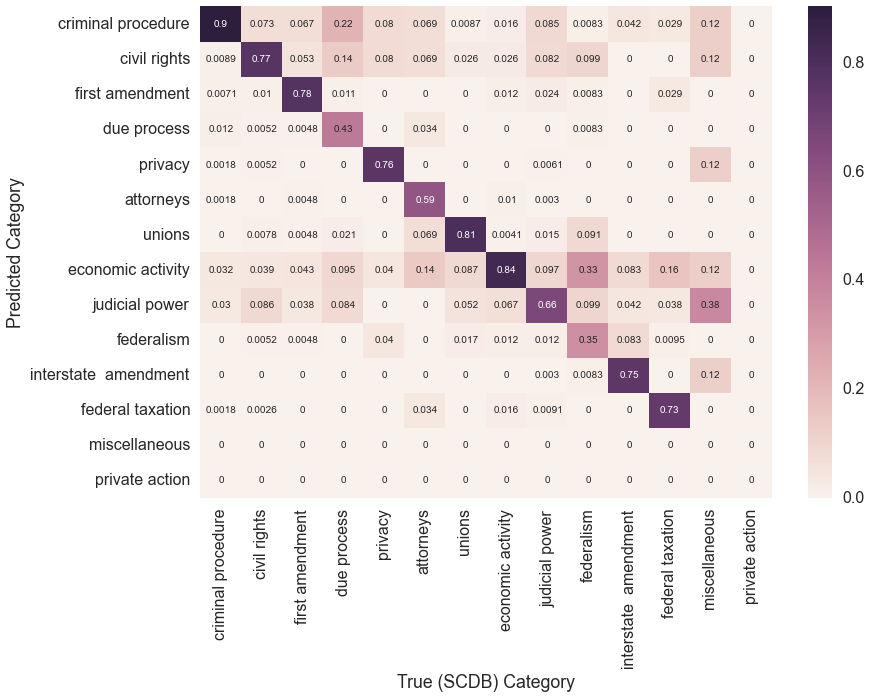

In [171]:
#HEAT MAP
#issue areas
issue_areas = ["criminal procedure","civil rights","first amendment","due process","privacy","attorneys",
              "unions","economic activity","judicial power","federalism","interstate  amendment",
              "federal taxation","miscellaneous","private action"]
#print bar graph
best_con_mat = np.array(best_con_mat).T
best_con_mat = map(lambda row : map(float,row) / sum(row) if sum(row) > 0 else map(float,row), np.array(best_con_mat))
best_con_mat = np.array(best_con_mat).T
sns.heatmap(best_con_mat, annot=True, xticklabels=issue_areas, yticklabels=issue_areas)
sns.axlabel('True (SCDB) Category', 'Predicted Category')

This is very similar to what we saw for the subsample, and the generally dark main diagonal of the heat map implies that the model tended to be accurate across most categories. The darker off-diagonal entries do show some of the more common errors that the model tends to make in the larger dataset; for example, due process cases are often incorrectly classified into the criminal procedure topic area.

#Naive Bayes

To go directly to Naive Bayes results, click <a href='#nb_results'>here</a>.

As we did in the Naive Bayes file, we start by adding extra dummy columns to the `all_data` DataFrame.

In [69]:
# turn issue areas into dummy column
issue_areas = ["criminal procedure","civil rights","first amendment","due process","privacy","attorneys",
              "unions","economic activity","judicial power","federalism","interstate  amendment",
              "federal taxation","miscellaneous","private action"]

for issue, num in zip(issue_areas,range(1,15)):
    all_data[issue] = all_data.issueArea.apply(lambda x: 1 if x == num else 0)

In [70]:
# turn decision directions into dummy column (conservative, liberal, neutral)
decision_areas = ["conservative","liberal","neutral"]

for decision, num in zip(decision_areas,range(1,4)):
    all_data[decision] = all_data.decisionDirection.apply(lambda x: 1 if x == num else 0)

In [71]:
all_data.head()

,full_cite,text,url,us_cite,case,case_id,caseId,docketId,usCite,docket,dateArgument,caseOriginState,jurisdiction,issueArea,decisionDirection,decisionType,lawType,majOpinWriter,majVotes,minVotes,year,training,criminal procedure,civil rights,first amendment,due process,privacy,attorneys,unions,economic activity,judicial power,federalism,interstate amendment,federal taxation,miscellaneous,private action,conservative,liberal,neutral
0,Eagles v. Samuels 329 U.S. 304 (1946),"Eagles v. Samuels No. 59 Argued November 21, 1...",https://supreme.justia.com/cases/federal/us/32...,329 U.S. 304,Eagles v. Samuels,0,1946-020,1946-020-01,329 U.S. 304,59,11/21/1946,35,1,3,1,1,3,81,9,0,1946,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,Eagles v. Horowitz 329 U.S. 317 (1946),"Eagles v. Horowitz No. 58 Argued November 21, ...",https://supreme.justia.com/cases/federal/us/32...,329 U.S. 317,Eagles v. Horowitz,1,1946-021,1946-021-01,329 U.S. 317,58,11/21/1946,35,1,3,1,1,3,81,9,0,1946,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,Labor Board v. A. J. Tower Co. 329 U.S. 324 (1...,Labor Board v. A. J. Tower Co. No. 60 Argued N...,https://supreme.justia.com/cases/federal/us/32...,329 U.S. 324,Labor Board v. A. J. Tower Co.,2,1946-022,1946-022-01,329 U.S. 324,60,11/21/1946,NaN,1,7,2,1,3,82,8,1,1946,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0
3,Gibson v. United States 329 U.S. 338 (1946),Gibson v. United States No. 23 Argued January ...,https://supreme.justia.com/cases/federal/us/32...,329 U.S. 338,Gibson v. United States,3,1946-023,1946-023-01,329 U.S. 338,23,1/2/1946,49,1,3,2,1,3,85,9,0,1946,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,Illinois v. Campbell 329 U.S. 362 (1946),Illinois ex rel. Gordon v. Campbell No. 35 Arg...,https://supreme.justia.com/cases/federal/us/32...,329 U.S. 362,Illinois v. Campbell,4,1946-024,1946-024-01,329 U.S. 362,35,3/28/1946,17,1,12,2,1,3,85,7,2,1946,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0


### Vectorizing Text

As in the NB notebook, we use **make_xy** to convert the syllabi (a collection of text documents) to numerical data (a matrix of token counts). The default vectorizer we use for this task is CountVectorizer, which produces a sparse representation of the counts.

In [72]:
# function (from lab 9) to vectorize text - adapted to accomodate topics
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix

def make_xy(df, issue, vectorizer=None):   
    if vectorizer is None:
        vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(df.text)
    X = X.tocsc()
    y = (df[issue] == 1).values.astype(np.int)
    return X, y

### Model Calibration

The following function produces a calibration plot. In theory, if the model is perfectly calibrated, the line plot should follow the 45-degree line *y=x*.

In [87]:
"""
Function
--------
calibration_plot
Builds a plot from a classifier and review data

Inputs
-------
clf : Classifier object
    A MultinomialNB classifier
X : (Nexample, Nfeature) array
    The bag-of-words data
Y : (Nexample) integer array
    1 if an opinion is in a certain topic
"""    

def calibration_plot(clf, issue, xtest, ytest):
    prob = clf.predict_proba(xtest)[:, 1]
    outcome = ytest
    data = pd.DataFrame(dict(prob=prob, outcome=outcome))

    #group outcomes into bins of similar probability
    bins = np.linspace(0, 1, 20)
    cuts = pd.cut(prob, bins)
    binwidth = bins[1] - bins[0]
    
    #topic ratio and number of examples in each bin
    cal = data.groupby(cuts).outcome.agg(['mean', 'count'])
    cal['pmid'] = (bins[:-1] + bins[1:]) / 2
    cal['sig'] = np.sqrt(cal.pmid * (1 - cal.pmid) / cal['count'])
        
    #the calibration plot
    ax = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
    p = plt.errorbar(cal.pmid, cal['mean'], cal['sig'], color='#7ddbca')
    plt.plot(cal.pmid, cal.pmid, linestyle='--', lw=1, color='#7ddbca')
    plt.ylabel("Empirical P(%s)" % issue)
    
    #the distribution of P(topic)
    ax = plt.subplot2grid((3, 1), (2, 0), sharex=ax)
    
    plt.bar(left=cal.pmid - binwidth / 2, height=cal['count'],
            width=.95 * (bins[1] - bins[0]),
            fc=p[0].get_color(), alpha=0.7, linewidth=0)
    
    plt.xlabel("Predicted P(%s)" % issue)
    plt.ylabel("Number")

### Running the Model

Using the supporting functions above, we can now classify each issue area and store the output. One difference now is that we do not need to reuse cross-validation; since we already used cross-validation to determine optimal parameters for each topic area within the subsample data (in the Naive Bayes notebook), we can just use those optimal parameters here by loading them from a csv.

In theory, we could do 5-fold cross-validation again using the whole dataset. However, given the massive size of the dataset, this would be practically impossible, so we have decided to use the optimal parameters computed for the subsample.

The following DataFrame contains the subsample results, computed and outputted in the Naive Bayes file.

In [75]:
nb_sample_results = pd.read_csv('naive_bayes_sample_model_results.csv')

In [85]:
nb_sample_results.head()

,best alpha,best min_df,fn,fp,issue,test_accuracy,tn,tp,training_accuracy,words,sensitivity,specificity
0,50.0,0.1,24,40,criminal procedure,0.866388,68,347,0.880824,"[convicted, jury, trial, conviction, defendant...",0.935310,0.629630
1,10.0,0.1,59,46,civil rights,0.780793,35,339,0.809140,"[protection, persons, her, opportunity, requir...",0.851759,0.432099
2,0.1,0.1,36,27,first amendment,0.868476,24,392,0.938172,"[public, first, exercise, interest, interests,...",0.915888,0.470588
3,5.0,0.1,16,8,due process,0.949896,5,450,0.956093,"[property, due, process, hearing, opportunity,...",0.965665,0.384615
4,1.0,0.1,10,4,privacy,0.970772,0,465,0.982079,"[board, relevant, related, procedure, enforcem...",0.978947,0.000000


The `optimal_params` dictionary contains the optimal alpha and min_df parameters for each topic area.

In [86]:
optimal_params = zip(nb_sample_results['best alpha'].tolist(), nb_sample_results['best min_df'].tolist())
optimal_params = zip(nb_sample_results['issue'].tolist(), optimal_params)
optimal_params = dict(optimal_params)
optimal_params

{'attorneys': (1.0, 0.10000000000000001),
 'civil rights': (10.0, 0.10000000000000001),
 'criminal procedure': (50.0, 0.10000000000000001),
 'due process': (5.0, 0.10000000000000001),
 'economic activity': (10.0, 0.10000000000000001),
 'federal taxation': (5.0, 0.10000000000000001),
 'federalism': (10.0, 0.10000000000000001),
 'first amendment': (0.10000000000000001, 0.10000000000000001),
 'interstate  amendment': (5.0, 0.10000000000000001),
 'judicial power': (10.0, 0.10000000000000001),
 'miscellaneous': (1.0, 0.10000000000000001),
 'privacy': (1.0, 0.10000000000000001),
 'unions': (10.0, 0.10000000000000001)}

This function splits a df into training and test data, fits a Naive Bayes model on the training data, and provides useful output
about the performance of the model on the training and test data while storing relevant results in global dictionaries and lists.

In [116]:
def run_multinb(df, issue):
    # create a mask to split data into test and training sets
    itrain, itest = train_test_split(xrange(df.shape[0]), train_size=0.7)
    mask = np.ones(df.shape[0], dtype='int')
    mask[itrain] = 1
    mask[itest] = 0
    mask = (mask == 1)
    
    best_alpha, best_min_df = optimal_params[issue]
    
    print issue.upper()
    print "---------------"
    
    vectorizer = CountVectorizer(min_df = best_min_df)
    X, y = make_xy(df, issue, vectorizer)
    xtrain, ytrain, xtest, ytest = X[mask], y[mask], X[~mask], y[~mask]
    clf = MultinomialNB(alpha=best_alpha).fit(xtrain, ytrain)

    # store and print train and test accuracy
    print "------"
    train_acc.append(clf.score(xtrain, ytrain))
    test_acc.append(clf.score(xtest, ytest))
    print "Accuracy on training data: %0.2f" % (clf.score(xtrain, ytrain))
    print "Accuracy on test data:     %0.2f" % (clf.score(xtest, ytest))
    
    # store and print true/false pos/negs
    tp.append(confusion_matrix(ytest, clf.predict(xtest))[0][0])
    fp.append(confusion_matrix(ytest, clf.predict(xtest))[1][0])
    fn.append(confusion_matrix(ytest, clf.predict(xtest))[0][1])
    tn.append(confusion_matrix(ytest, clf.predict(xtest))[1][1])
    print "------"
    print "True positives:", confusion_matrix(ytest, clf.predict(xtest))[0][0]
    print "False positives:", confusion_matrix(ytest, clf.predict(xtest))[1][0]
    print "False negatives:", confusion_matrix(ytest, clf.predict(xtest))[0][1]
    print "True negatives:", confusion_matrix(ytest, clf.predict(xtest))[1][1]
    
    # get features from results
    words = np.array(vectorizer.get_feature_names())
    x = np.eye(xtest.shape[1])
    probs = clf.predict_log_proba(x)[:, 0]
    ind = np.argsort(probs)

    # top 10 words associated with topic
    good_prob = probs[ind[:10]]
    good_words = words[ind[:10]]
    rep_words.append(good_words)

    print "------"
    print "Words yielding highest P(%s | word)" % issue
    for w, p in zip(good_words, good_prob):
        print "%20s" % w, "%0.2f" % (1 - np.exp(p))
    
    # predict probability of belonging to topic
    prob = clf.predict_proba(X)[:, 0]
    prob_dict[issue] = prob
    predict = clf.predict(X)
    predict_dict[issue] = predict
    
    # print false positives and false negatives
    bad_fp = np.argsort(prob[y == 0])[:5]
    bad_fn = np.argsort(prob[y == 1])[-5:]
    
    print "False positive cases:"
    print '---------------------------'
    for row in bad_fp:
        print df[y == 0].case.irow(row)

    print
    print "False negative cases:"
    print '--------------------------'
    for row in bad_fn:
        print df[y == 1].case.irow(row)
    
    # calibration plot
    calibration_plot(clf, issue, xtest, ytest)

The next several cells just run the `run_multinb` function above on the topic areas in order.

CRIMINAL PROCEDURE
---------------
------
Accuracy on training data: 0.87
Accuracy on test data:     0.86
------
True positives: 1682
False positives: 125
False negatives: 228
True negatives: 417
------
Words yielding highest P(criminal procedure | word)
           convicted 0.67
          conviction 0.67
                jury 0.64
               trial 0.62
            criminal 0.60
           defendant 0.57
            evidence 0.49
               judge 0.47
                  he 0.46
                 his 0.44
False positive cases:
---------------------------
Clark v. Arizona
Lafler v. Cooper
Ballard v. Commissioner
Strickland v. Washington
Drope v. Missouri

False negative cases:
--------------------------
Beck v. Prupis
Boumediene v. Bush
Klehr v. A. O. Smith Corp.
Medellín v. Texas
North Star Steel Co. v. Thomas


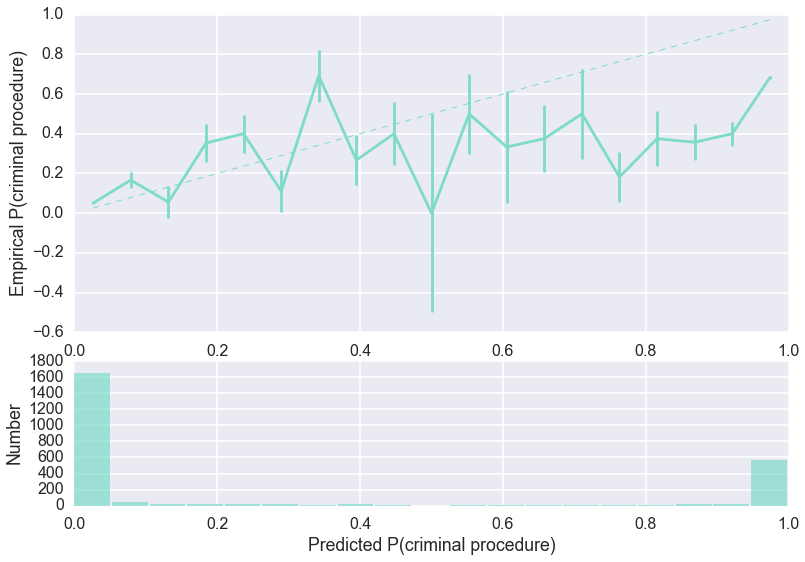

In [133]:
train_acc,test_acc,tp,fp,tn,fn,rep_words = [],[],[],[],[],[],[]
predict_dict = {}
prob_dict = {}

# start with issue 1 (criminal procedure)
run_multinb(all_data, issue_areas[0])

CIVIL RIGHTS
---------------
------
Accuracy on training data: 0.81
Accuracy on test data:     0.80
------
True positives: 1759
False positives: 190
False negatives: 307
True negatives: 196
------
Words yielding highest P(civil rights | word)
               equal 0.55
          protection 0.36
              rights 0.27
          fourteenth 0.27
                supp 0.26
               civil 0.26
               white 0.25
      administrative 0.24
         appropriate 0.24
             members 0.24
False positive cases:
---------------------------
Chapman v. Houston Welfare Rights Organization
Chem. Mfrs. Ass'n v. NRDC
Vieth v. Jubelirer
Planned Parenthood of Southeastern Pa. v. Casey
City of Riverside v. Rivera

False negative cases:
--------------------------
Ake v. Oklahoma
Martinez v. Ryan
Strickland v. Washington
Lafler v. Cooper
Trevino v. Thaler


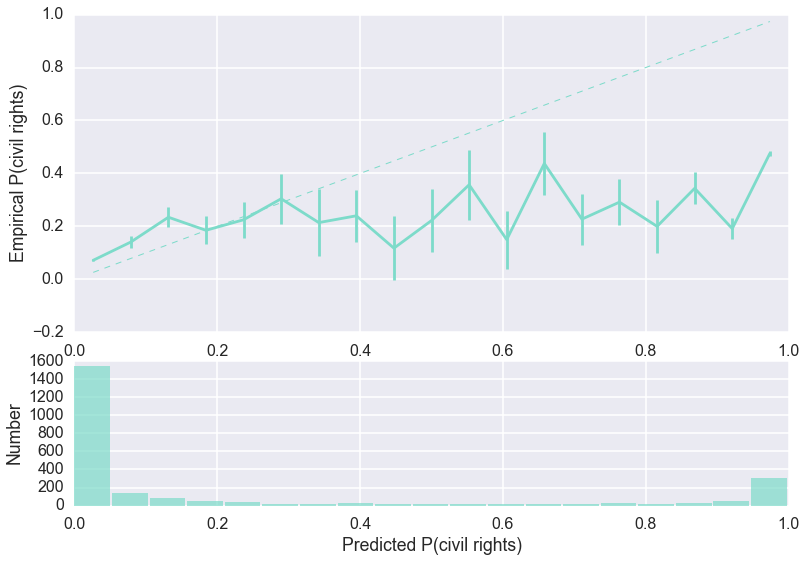

In [134]:
run_multinb(all_data, issue_areas[1])

FIRST AMENDMENT
---------------
------
Accuracy on training data: 0.87
Accuracy on test data:     0.87
------
True positives: 2010
False positives: 72
False negatives: 244
True negatives: 126
------
Words yielding highest P(first amendment | word)
               first 0.30
              public 0.25
           amendment 0.22
               party 0.19
          fourteenth 0.17
            interest 0.17
             applied 0.16
           interests 0.16
             violate 0.16
             justice 0.15
False positive cases:
---------------------------
Planned Parenthood of Southeastern Pa. v. Casey
Lehnert v. Ferris Faculty Ass'n
City of Richmond v. J. A. Croson Co.
Webster v. Reproductive Health Svcs.
Grutter v. Bollinger

False negative cases:
--------------------------
United States v. Sisson
Mt. Healthy City Sch. Dist. v. Doyle
Cort v. Ash
El Vocero de Puerto Rico v. Puerto Rico
Oklahoma v. United States Civil Service Comm'n


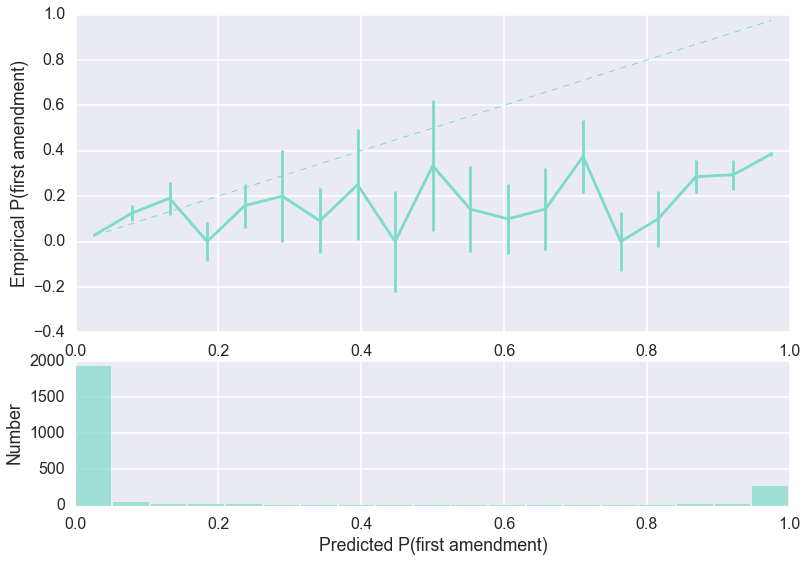

In [135]:
run_multinb(all_data, issue_areas[2])

DUE PROCESS
---------------
------
Accuracy on training data: 0.89
Accuracy on test data:     0.88
------
True positives: 2113
False positives: 56
False negatives: 226
True negatives: 57
------
Words yielding highest P(due process | word)
                 due 0.22
            property 0.18
             process 0.18
             hearing 0.15
            interest 0.10
          fourteenth 0.09
           interests 0.08
               judge 0.07
           defendant 0.07
               prior 0.07
False positive cases:
---------------------------
Levine v. United States
Connecticut v. Doehr
Turner v. Rogers, et al.
United States v. Craft
Pennsylvania v. Ritchie

False negative cases:
--------------------------
Daimler AG v. Bauman
Cornelius v. Nutt
Howe v. Smith
San Remo Hotel, L. P. v. City and County of San Francisco
United States v. Windsor


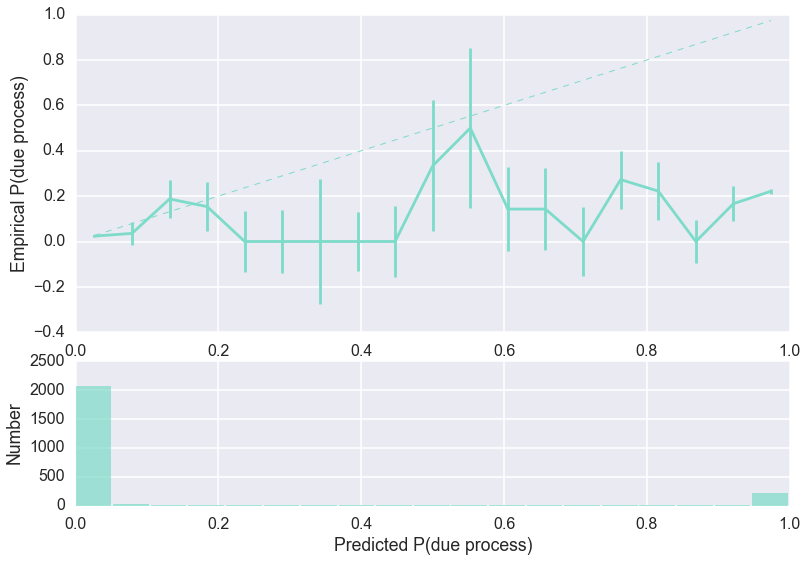

In [136]:
run_multinb(all_data, issue_areas[3])

PRIVACY
---------------
------
Accuracy on training data: 0.90
Accuracy on test data:     0.88
------
True positives: 2148
False positives: 12
False negatives: 270
True negatives: 22
------
Words yielding highest P(privacy | word)
           interests 0.05
         requirement 0.04
              public 0.04
            interest 0.04
           procedure 0.04
           necessary 0.04
           available 0.03
                need 0.03
             seeking 0.03
             provide 0.03
False positive cases:
---------------------------
McConnell v. Federal Election Comm'n
Chem. Mfrs. Ass'n v. NRDC
League of United Latin American Citizens v. Perry
Parents Involved in Community Schools v. Seattle School Dist. No.
County of Allegheny v. ACLU

False negative cases:
--------------------------
GTE Sylvania, Inc. v. Consumers Union
United States v. Vuitch
United States ex rel. Touhy v. Ragen
United States v. Reynolds
Hickman v. Taylor


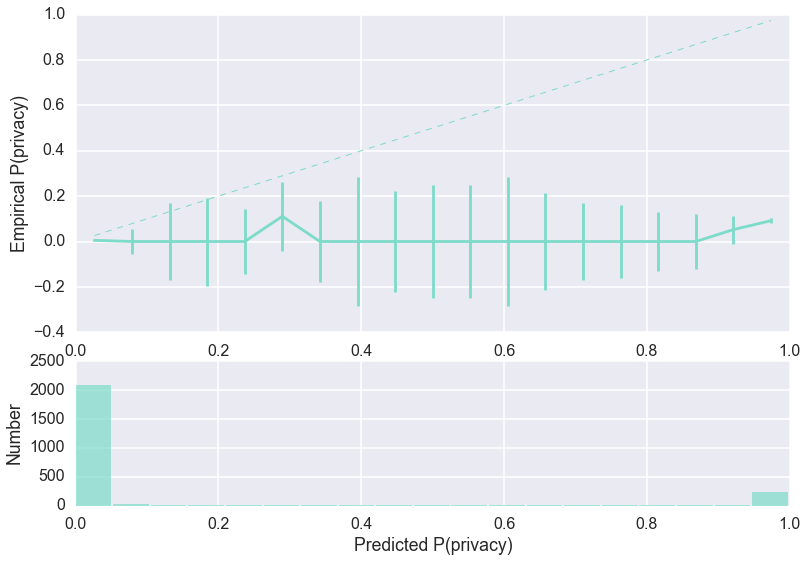

In [137]:
run_multinb(all_data, issue_areas[4])

ATTORNEYS
---------------
------
Accuracy on training data: 0.96
Accuracy on test data:     0.95
------
True positives: 2322
False positives: 11
False negatives: 105
True negatives: 14
------
Words yielding highest P(attorneys | word)
            attorney 0.13
               party 0.05
          reasonable 0.04
               civil 0.03
            practice 0.03
          authorized 0.03
              rights 0.03
                text 0.02
              connor 0.02
             damages 0.02
False positive cases:
---------------------------
National Private Truck Council, Inc. v. Oklahoma Tax Comm'n
Kimberlin v. Quinlan
Tennessee v. Middlebrooks
Business Guides v. Chromatic Commun.
Cooter & Gell v. Hartmarx

False negative cases:
--------------------------
Theard v. United States
In re Disbarment of Isserman
In re Snyder
Konigsberg v. State Bar of California
Schware v. Board of Bar Examiners


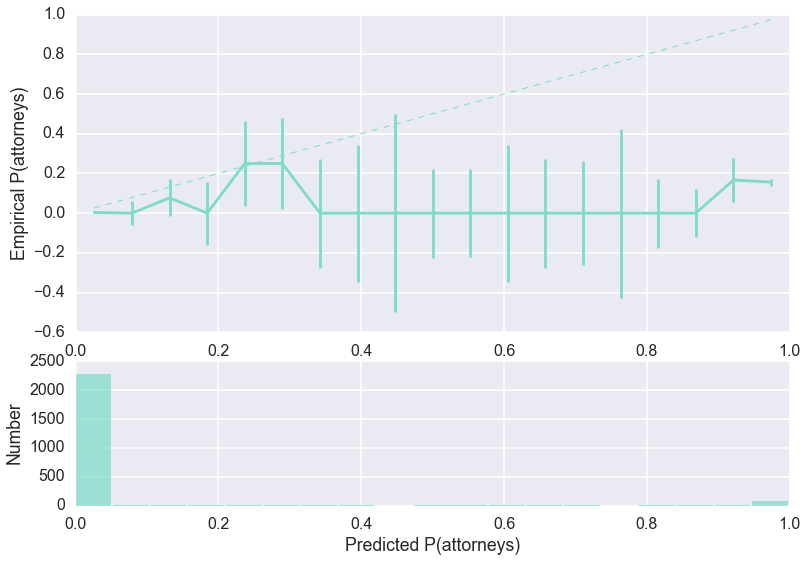

In [138]:
run_multinb(all_data, issue_areas[5])

UNIONS
---------------
------
Accuracy on training data: 0.91
Accuracy on test data:     0.91
------
True positives: 2141
False positives: 21
False negatives: 200
True negatives: 90
------
Words yielding highest P(unions | word)
           employees 0.36
            national 0.23
               board 0.23
            practice 0.18
             members 0.12
                corp 0.09
             meaning 0.09
               terms 0.08
            violated 0.08
            business 0.08
False positive cases:
---------------------------
Sure-Tan, Inc. v. NLRB
Railway Clerks v. Employees Ass'n
Chem. Mfrs. Ass'n v. NRDC
Labor Board v. Jones & Laughlin Steel Corp.
Renegotiation Bd. v. Grumman Aircraft

False negative cases:
--------------------------
Major League Baseball Players Assn. v. Garvey
United Transp. Union v. Long Island R. Co.
Genesis HealthCare Corp. v. Symczyk
Atlantic Coast L. R. Co. v. Engineers
Davenport v. Washington Ed. Assn.


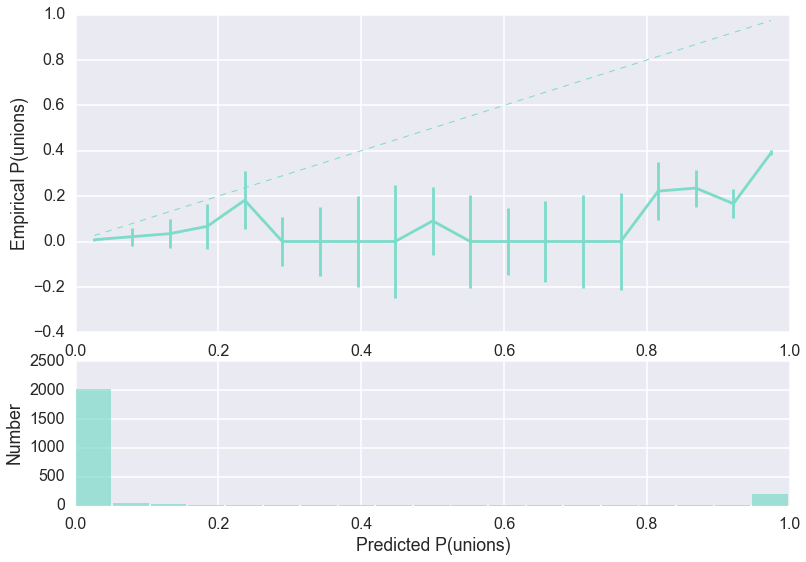

In [139]:
run_multinb(all_data, issue_areas[6])

ECONOMIC ACTIVITY
---------------
------
Accuracy on training data: 0.75
Accuracy on test data:     0.74
------
True positives: 1452
False positives: 104
False negatives: 533
True negatives: 363
------
Words yielding highest P(economic activity | word)
           liability 0.50
                corp 0.46
             damages 0.45
            business 0.43
                  co 0.40
          commission 0.40
                 inc 0.39
                 act 0.33
                laws 0.32
             summary 0.30
False positive cases:
---------------------------
National Cable & Telecommunications Assn. v. Brand X Internet Services
FAA v. Cooper
United States v. Rock Island Motor Transit Co.
Meyer v. Holley
FTC v. Cement Institute

False negative cases:
--------------------------
Moore v. City of East Cleveland
Weisgram v. Marley Co.
First Nat'l Bank v. Cities Service Co.
Kelly v. Robinson
Conn v. Gabbert


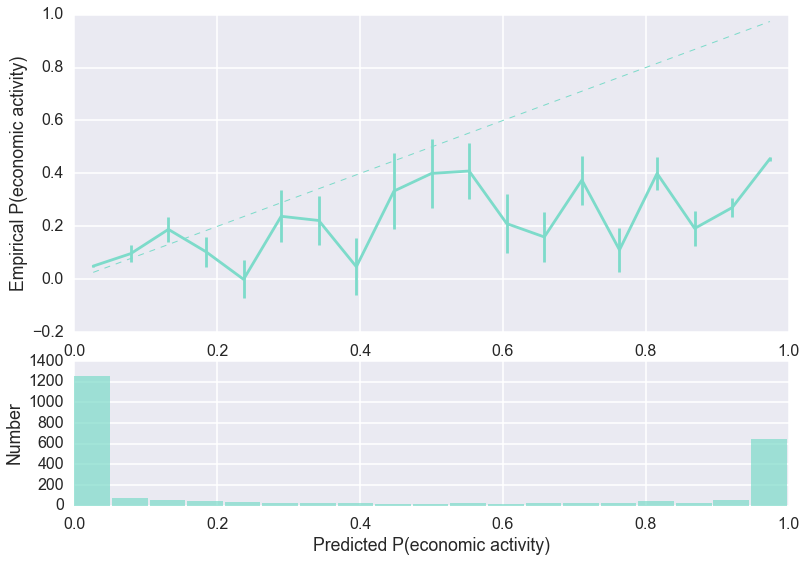

In [140]:
run_multinb(all_data, issue_areas[7])

JUDICIAL POWER
---------------
------
Accuracy on training data: 0.78
Accuracy on test data:     0.76
------
True positives: 1615
False positives: 63
False negatives: 524
True negatives: 250
------
Words yielding highest P(judicial power | word)
        jurisdiction 0.40
           dismissed 0.36
              review 0.35
              appeal 0.33
           complaint 0.31
      administrative 0.30
                  28 0.30
                suit 0.29
             vacated 0.28
               order 0.28
False positive cases:
---------------------------
Vaden v. Discover Bank
Mims v. Arrow Financial Services, LLC
Arbaugh v. Y & H Corp.
Stone v. INS
Kloeckner v. Solis

False negative cases:
--------------------------
Vieth v. Jubelirer
Rogers v. United States
City of Los Angeles v. Lyons
Piper Aircraft Co. v. Reyno
Valley Forge Coll. v. Americans United


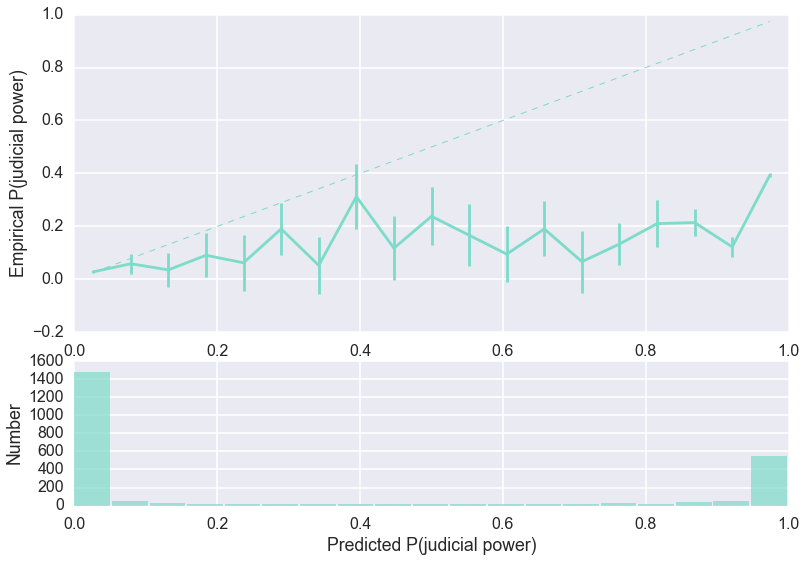

In [141]:
run_multinb(all_data, issue_areas[8])

FEDERALISM
---------------
------
Accuracy on training data: 0.86
Accuracy on test data:     0.86
------
True positives: 2024
False positives: 35
False negatives: 305
True negatives: 88
------
Words yielding highest P(federalism | word)
                laws 0.13
               state 0.12
            national 0.12
            congress 0.11
             federal 0.11
               power 0.11
        requirements 0.10
             entered 0.10
           authority 0.09
        constitution 0.09
False positive cases:
---------------------------
McConnell v. Federal Election Comm'n
Mims v. Arrow Financial Services, LLC
Granholm v. Heald
Medellín v. Texas
Fed. Trade Comm'n v. Phoebe Putney Health Sys., Inc.

False negative cases:
--------------------------
Hisquierdo v. Hisquierdo
Bill Johnson's Restaurants, Inc. v. NLRB
Greenwood v. United States
James M. Beam Distilling Co. v. Georgia
Cousins v. Wigoda


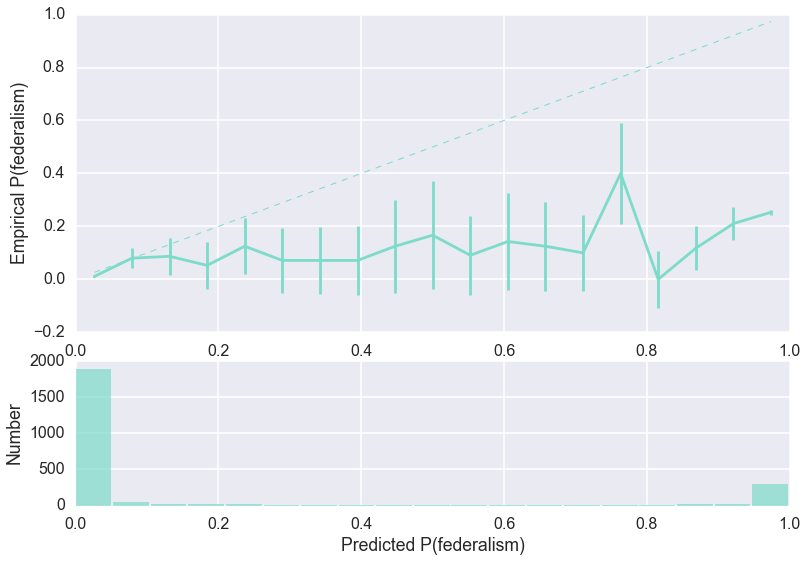

In [142]:
run_multinb(all_data, issue_areas[9])

INTERSTATE  AMENDMENT
---------------
------
Accuracy on training data: 0.88
Accuracy on test data:     0.87
------
True positives: 2127
False positives: 5
False negatives: 304
True negatives: 16
------
Words yielding highest P(interstate  amendment | word)
             entered 0.08
                 new 0.05
             between 0.03
              having 0.03
           complaint 0.03
             parties 0.03
                long 0.03
            february 0.03
            december 0.03
          determined 0.03
False positive cases:
---------------------------
Arizona v. California
United States v. California
United States v. Louisiana
United States v. California
United States v. Louisiana

False negative cases:
--------------------------
Baker v. General Motors Corp.
Morris v. Jones
Union National Bank v. Lamb
Franchise Tax Bd. of Cal. v. Hyatt
Industrial Comm'n of Wisconsin v. McCartin


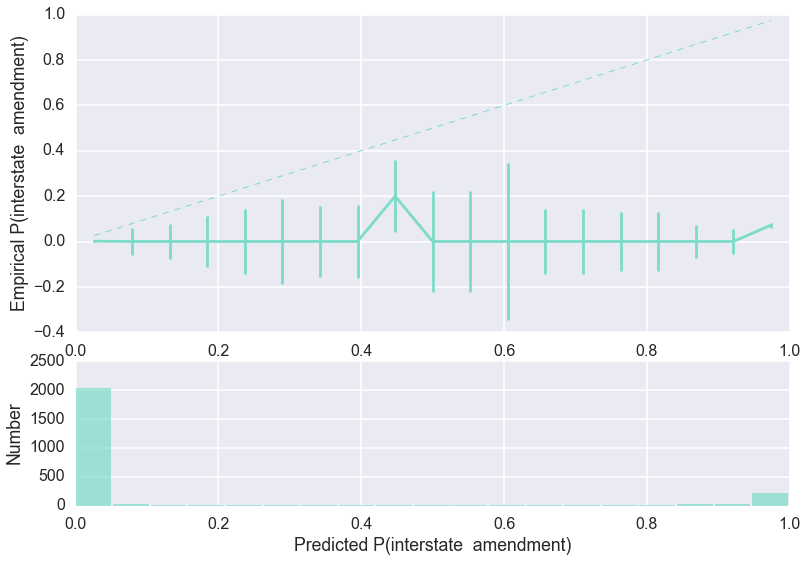

In [143]:
run_multinb(all_data, issue_areas[10])

FEDERAL TAXATION
---------------
------
Accuracy on training data: 0.83
Accuracy on test data:     0.83
------
True positives: 1958
False positives: 9
False negatives: 403
True negatives: 82
------
Words yielding highest P(federal taxation | word)
            property 0.18
                  26 0.15
               years 0.12
            business 0.11
          determined 0.11
                  23 0.09
             meaning 0.08
            interest 0.08
            entitled 0.08
                  22 0.07
False positive cases:
---------------------------
Department of Revenue of Ore. v. ACF Industries, Inc.
United States v. Whiting Pools, Inc.
Reiter v. Sonotone Corp.
Rake v. Wade
Northern Pacific Railway Co. v. United States

False negative cases:
--------------------------
United States v. Calderon
United States v. International Business Machines Corp.
United States v. Hatter
United States v. Carlton
United States v. Munoz-Flores


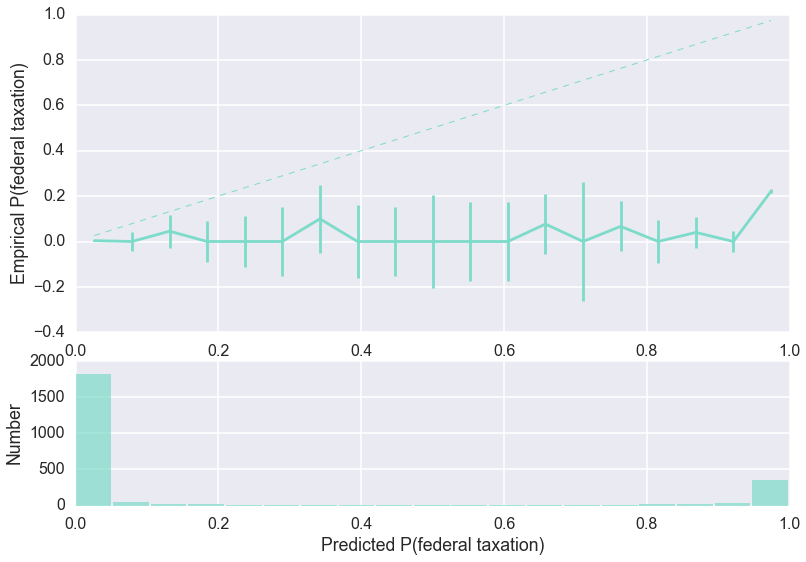

In [144]:
run_multinb(all_data, issue_areas[11])

MISCELLANEOUS
---------------
------
Accuracy on training data: 0.98
Accuracy on test data:     0.98
------
True positives: 2396
False positives: 5
False negatives: 49
True negatives: 2
------
Words yielding highest P(miscellaneous | word)
               power 0.01
        constitution 0.01
            exercise 0.01
              during 0.01
         legislative 0.01
            congress 0.01
           authority 0.01
              clause 0.01
               judge 0.01
            pursuant 0.01
False positive cases:
---------------------------
Brendale v. Confederated Tribes
Nat'l Fed'n of Indep. Bus. v. Sebelius
Boumediene v. Bush
Dames & Moore v. Regan
Medellín v. Texas

False negative cases:
--------------------------
Granville-Smith v. Granville-Smith
Department of Commerce v. United States House of Representatives
United States v. Stuart
Plaut v. Spendthrift Farm, Inc.
FNC Bank v. Banco Para el Comercio


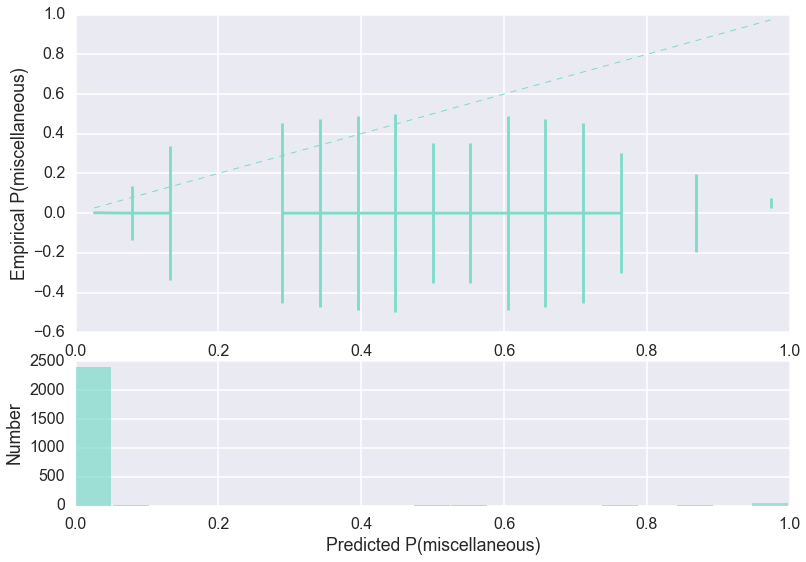

In [145]:
run_multinb(all_data, issue_areas[12])

Finally, we ideally would want to apply the Naive Bayes model to the cases in the private action area as well, but there are very few cases in that category:

In [146]:
all_data[all_data['private action'] == 1]

,full_cite,text,url,us_cite,case,case_id,caseId,docketId,usCite,docket,dateArgument,caseOriginState,jurisdiction,issueArea,decisionDirection,decisionType,lawType,majOpinWriter,majVotes,minVotes,year,training,criminal procedure,civil rights,first amendment,due process,privacy,attorneys,unions,economic activity,judicial power,federalism,interstate amendment,federal taxation,miscellaneous,private action,conservative,liberal,neutral,predicted_issue_area,predicted_correctly
7885,Stern v. Marshall 564 U.S. ___ (2011),"STERN, EXECUTOR OF THE ESTATE OF MARSHALL v. M...",https://supreme.justia.com/cases/federal/us/56...,564 U.S. 10-179,Stern v. Marshall,10890,2010-079,2010-079-01,564 U.S. 10-179,10-179,1/18/2011,NaN,1,14,3,1,6,111,5,4,2010,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,"[13, 9, 2]",0
8115,Marvin M. Brandt Revocable Trust v. United Sta...,"NOTE: Where it is feasible, a syllabus (headno...",https://supreme.justia.com/cases/federal/us/57...,572 U.S. 12-1173,Marvin M. Brandt Revocable Trust v. United States,11143,2013-029,2013-029-01,572 U.S. 12-1173,12-1173,1/14/2014,NaN,1,14,3,1,6,111,8,1,2013,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,"[8, 5, 12]",0


Since there are only 2 cases in the entire dataset in the private action topic area (and neither of these cases ended up in the smaller subsample that we used), it would not be feasible to fit a model or compute predictions for this category.

Just as for the subsample, the calibration plots for the less common topic areas (e.g. miscellaneous, interstate amendment) are very skewed by the smaller number of observations (relative to the larger categories). The calibration plot lines tend to be very flat, and they often lie significantly below the *y=x* line at the very right side of the plots, implying that the models tend to underestimate the probabilities of a case belonging in a topic when those probabilities are high.

<a id='nb_results'></a>

### Naive Bayes: Accuracy by Aggregated Probabilities

Just as we did for the subsample in the Naive Bayes notebook, we can assign each case to a cluster (or a few clusters) by aggregating the topic probabilities generated by each binary model above and taking the maximum probabilities of these arrays, to identify which topics any given case is most likely to belong to.

In [147]:
# make the probabilities into a dataframe
prob_df = pd.DataFrame(prob_dict)
prob_df = prob_df[issue_areas[:-1]]
prob_df.head()

,criminal procedure,civil rights,first amendment,due process,privacy,attorneys,unions,economic activity,judicial power,federalism,interstate amendment,federal taxation,miscellaneous
0,0.999943,0.994394,1.000000,0.998309,1,1,7.409543e-02,0.999998,0.999990,1.000000,1.000000,1.000000e+00,1
1,0.470875,0.997869,0.999982,0.999966,1,1,7.068048e-01,0.697875,0.944649,0.999997,0.987864,2.282414e-04,1
2,1.000000,0.999971,0.999994,1.000000,1,1,1.435161e-13,0.983829,0.997976,0.999998,1.000000,9.999996e-01,1
3,0.000107,0.999991,1.000000,0.999702,1,1,1.000000e+00,1.000000,0.998733,1.000000,1.000000,9.951510e-01,1
4,1.000000,0.999997,1.000000,0.213796,1,1,1.000000e+00,0.000459,0.999922,0.997073,0.999928,5.289305e-14,1


As we explain in the Naive Bayes notebook, we decided that it would be best to assign each topic to 3 topic areas rather than a single one. To do this for any given case, we chose the topics with the *highest three* probabilities for that case. Then, we measure accuracy by examining whether the true Supreme Court Database topic area is one of the three assigned topics for a case.

In [175]:
import bottleneck as bn 

# make the probabilities into a matrix, and take top three topics associated with max values
prob_matrix = prob_df.as_matrix()
prob_issues = map(lambda x: list(bn.argpartsort(x,3)[:3]), prob_matrix)

In [149]:
# map indices to issue areas and add results to original dataframe
all_data["predicted_issue_area"] = [[x+1 for x in y] for y in prob_issues] 

# store correct predictions in a new accuracy column
all_data["predicted_correctly"] = [1 if x in y else 0 for y,x in zip(all_data["predicted_issue_area"], all_data["issueArea"])]
print "Accuracy across all issue areas: ", float(float(sum(all_data["predicted_correctly"]))/float(len(all_data)))

Accuracy across all issue areas:  0.814755903585


In [150]:
all_data[["issueArea","predicted_correctly","predicted_issue_area"]].head()

,issueArea,predicted_correctly,predicted_issue_area
0,3,0,"[7, 2, 4]"
1,3,0,"[12, 1, 8]"
2,7,1,"[7, 8, 9]"
3,3,0,"[1, 12, 9]"
4,12,1,"[8, 12, 4]"


So, even for the entire dataset, Naive Bayes does produce a high accuracy rate when assigning 3 topics to each case.

### Exploring Results

Now, as we did for the subsample, we can plot the performance of each model from above, measured by test vs. training data accuracy, sensitivity or true positive rate, and specificity or true negative rate. We can also explore how predictions are distributed across the issue areas, and dig into the data by checking out the cases that had more than one category assigned to them.

In [152]:
# create dataframe of output from modeling
model_dict = {}
model_dict["issue"] = issue_areas[:-1]
model_dict["training_accuracy"] = train_acc
model_dict["test_accuracy"] = test_acc
model_dict["tp"] = tp
model_dict["tn"] = tn
model_dict["fp"] = fp
model_dict["fn"] = fn
model_dict["words"] = rep_words
model_df = pd.DataFrame(model_dict)

In [164]:
# calculate specificity (true neg rate) and sensitivity (true pos rate)
tpr = [float(float(a) / float(a+b)) for a,b in zip(tp,fn)]
tnr = [float(float(a) / float(a+b)) for a,b in zip(tn,fp)]
model_df["sensitivity"] = tpr
model_df["specificity"] = tnr

# save this csv for comparison for final notebook (on full data set)
model_df.to_csv("naive_bayes_full_model_results.csv", sep=',', encoding='utf-8',index=False)
model_df.head()

,fn,fp,issue,test_accuracy,tn,tp,training_accuracy,words,sensitivity,specificity
0,228,125,criminal procedure,0.856036,417,1682,0.873274,"[convicted, conviction, jury, trial, criminal,...",0.880628,0.769373
1,307,190,civil rights,0.797308,196,1759,0.808076,"[equal, protection, rights, fourteenth, supp, ...",0.851404,0.507772
2,244,72,first amendment,0.871126,126,2010,0.874148,"[first, public, amendment, party, fourteenth, ...",0.891748,0.636364
3,226,56,due process,0.884992,57,2113,0.894948,"[due, property, process, hearing, interest, fo...",0.903378,0.504425
4,270,12,privacy,0.884992,22,2148,0.900367,"[interests, requirement, public, interest, pro...",0.888337,0.647059


In [165]:
# explore top words associated with each topic area
for wordlist,issue in zip(model_df.words,issue_areas[:-1]):
    print issue.upper() + ": " + ", ".join(wordlist)

CRIMINAL PROCEDURE: convicted, conviction, jury, trial, criminal, defendant, evidence, judge, he, his
CIVIL RIGHTS: equal, protection, rights, fourteenth, supp, civil, white, administrative, appropriate, members
FIRST AMENDMENT: first, public, amendment, party, fourteenth, interest, applied, interests, violate, justice
DUE PROCESS: due, property, process, hearing, interest, fourteenth, interests, judge, defendant, prior
PRIVACY: interests, requirement, public, interest, procedure, necessary, available, need, seeking, provide
ATTORNEYS: attorney, party, reasonable, civil, practice, authorized, rights, text, connor, damages
UNIONS: employees, national, board, practice, members, corp, meaning, terms, violated, business
ECONOMIC ACTIVITY: liability, corp, damages, business, co, commission, inc, act, laws, summary
JUDICIAL POWER: jurisdiction, dismissed, review, appeal, complaint, administrative, 28, suit, vacated, order
FEDERALISM: laws, state, national, congress, federal, power, requireme

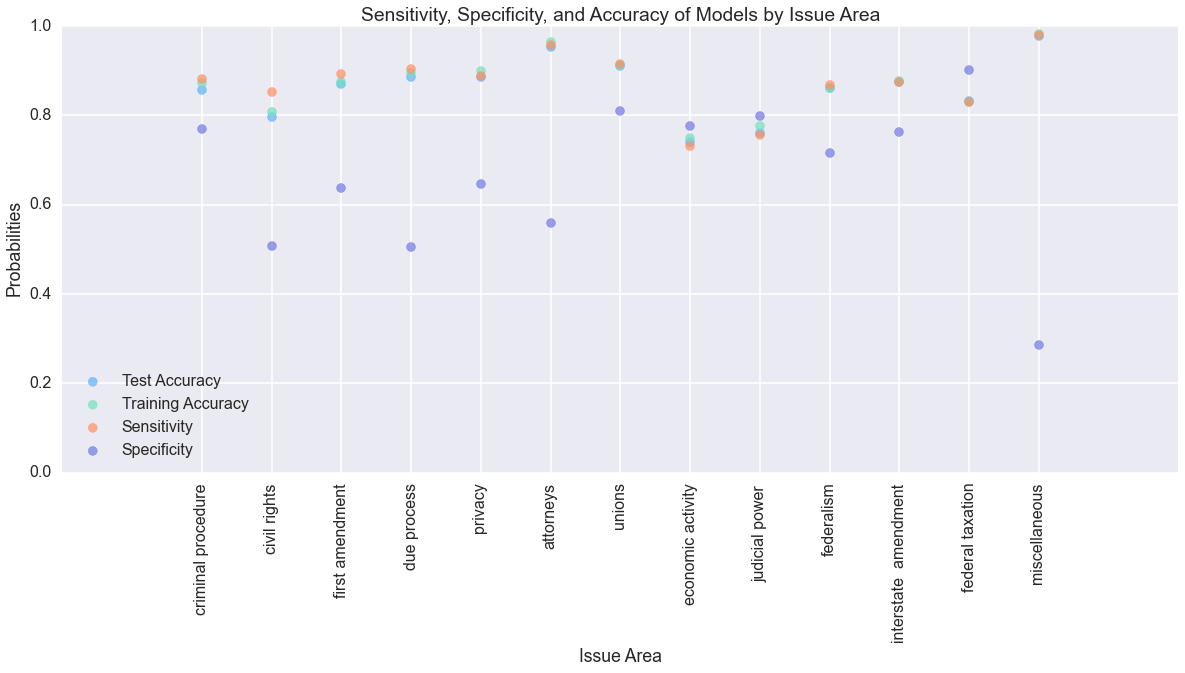

In [163]:
# plot training accuracy of each model
plt.figure(figsize=(20,8))
plt.scatter(range(len(model_df.test_accuracy)),model_df.test_accuracy, color="#5db0fd",label="Test Accuracy",s=80,alpha=0.7)
plt.scatter(range(len(model_df.training_accuracy)),model_df.training_accuracy, color="#73e1bd",label="Training Accuracy",s=80,alpha=0.7)
plt.scatter(range(len(model_df.sensitivity)),model_df.sensitivity, color="#ff9060",label="Sensitivity",s=80,alpha=0.7)
plt.scatter(range(len(model_df.specificity)),model_df.specificity, color="#7077e5",label="Specificity",s=80,alpha=0.7)
plt.xticks(np.arange(0,13,1),issue_areas[:-1], rotation=90)
plt.title("Sensitivity, Specificity, and Accuracy of Models by Issue Area")
plt.xlabel("Issue Area")
plt.ylabel("Probabilities")
plt.legend(loc="lower left")
plt.ylim((0,1))
plt.show()

Overall, the trends here are very similar to what we saw for the subsample in the Naive Bayes notebook. There are a couple of noticeable differences. First, the accuracy rates tend to be slightly lower for the larger sample than for the smaller sample, in several topic areas. On the other hand, the specificity tends to be much, much higher for the whole dataset than for the subsample alone, and this is especially true for the relatively smaller topic areas (like privacy and interstate amendment). This might be because a larger amount of data enables a more discerning fit with fewer false positives.

In [157]:
prediction s_df = pd.DataFrame(predict_dict)
predictions_df.head()

,attorneys,civil rights,criminal procedure,due process,economic activity,federal taxation,federalism,first amendment,interstate amendment,judicial power,miscellaneous,privacy,unions
0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,0,0,1,0,0,1,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,1
3,0,0,1,0,0,0,0,0,0,0,0,0,0
4,0,0,0,1,1,1,0,0,0,0,0,0,0


The following chart shows the number of cases classified into each topic area by the method above.

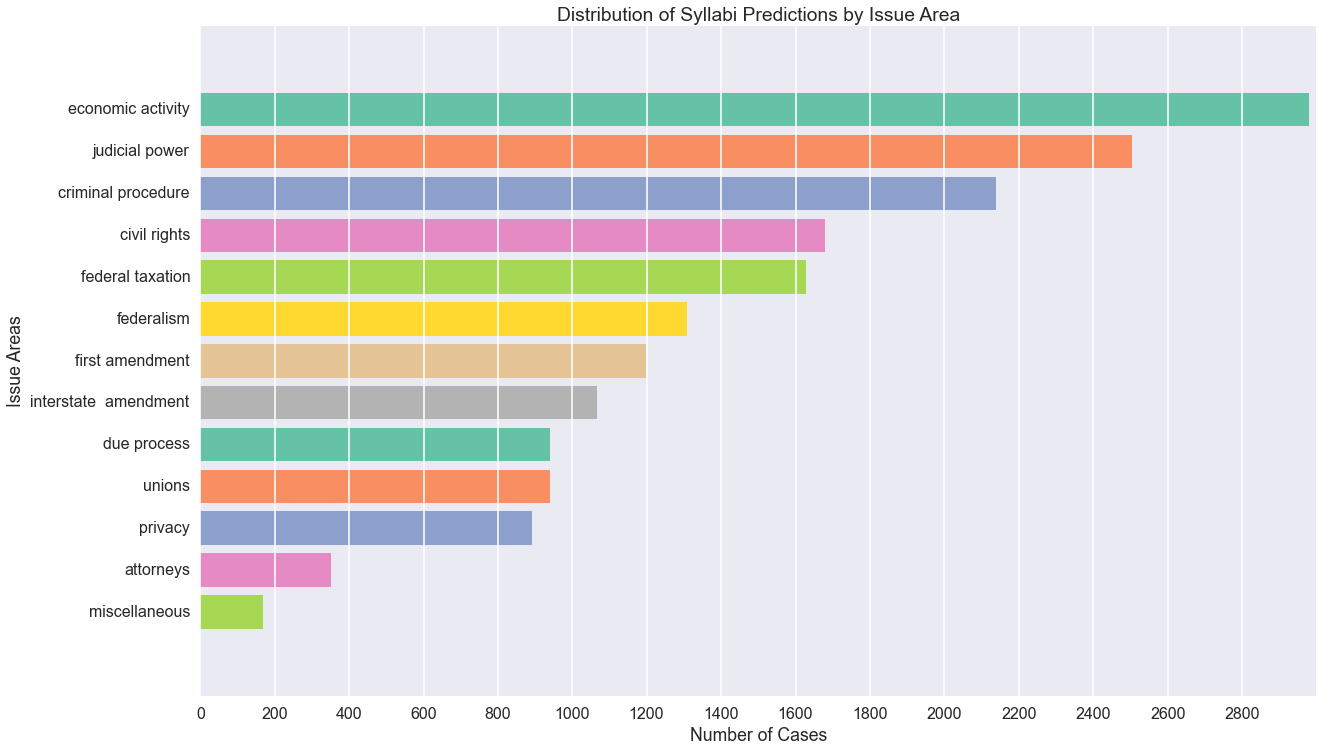

In [161]:
# plot distribution of all cases by issue type
import collections

issue_dict = {}
for issue in issue_areas[:-1]:
    issue_dict[issue] = sum(predictions_df[issue])

sorted_dict = collections.OrderedDict()
sorted_vals = sorted(issue_dict.values(),reverse=True)
sorted_keys = sorted(issue_dict, key=issue_dict.get,reverse=True)
for key, val in zip(sorted_keys,sorted_vals):
    sorted_dict[key] = val

plt.figure(figsize=(20,12))
plt.grid(zorder=3)
plt.barh(range(len(sorted_dict)),sorted_dict.values(),align='center',color=sns.color_palette("Set2", 14),linewidth=0,zorder=0)
plt.gca().yaxis.grid(False)
plt.gca().invert_yaxis()
plt.yticks(range(len(sorted_dict)),sorted_dict.keys())
plt.xticks(np.arange(0,3000,200))
plt.title("Distribution of Syllabi Predictions by Issue Area")
plt.xlabel("Number of Cases")
plt.ylabel("Issue Areas")
plt.show()

This looks roughly similar to the corresponding plot from the Naive Bayes notebook. However, one notable difference is that the less common topic areas (e.g. privacy and interstate amendment) now have many more cases assigned to them than they did with the subsample, as a proportion of the total predictions. This might be because the subsample had a very small number of cases within some of those categories, which led to a correspondingly small number of predicted case for those areas.

As we did for the subsample, we can also create a histogram showing the number of topics that were assigned to each case in the binary NB models above.

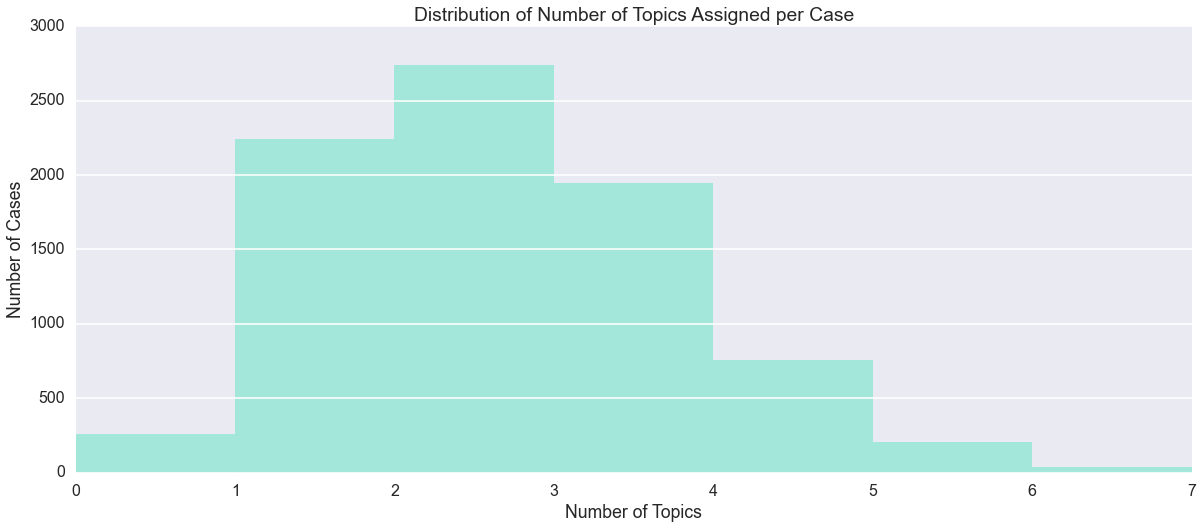

In [162]:
predictions_df["num_categories"] = predictions_df.sum(axis=1)
plt.figure(figsize=(20,8))
plt.hist(predictions_df.num_categories,bins=7,alpha=0.7,color="#84e7d1",linewidth=0,zorder=0)
plt.grid(zorder=3)
plt.gca().xaxis.grid(False)
plt.title("Distribution of Number of Topics Assigned per Case")
plt.xlabel("Number of Topics")
plt.ylabel("Number of Cases")
plt.show()

Interestingly, each case is more likely to be assigned to a larger number of topics for the whole dataset than for the subsample. In other words, there are far more cases assigned to 3, 4, 5 or more topics in the whole dataset than there were for the subsample. This might be because a larger dataset enables the use of a larger vocabulary, and if there are more words that are positively linked to each topic area, that might cause a larger quantity of cases to be placed into each topic area.